In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
path = "imdb_top_1000.csv"
df = pd.read_csv(path)
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


In [4]:
# add actors in one column and drop others
df['Stars'] = df['Star1'] + ', ' + df['Star2'] + ', ' + df['Star3'] + ', ' + df['Star4']
df.drop(['Star1', 'Star2','Star3', 'Star4'], axis=1, inplace=True)

In [5]:
# reform some columns' type
df['Released_Year'] = (df['Released_Year'].str.replace('PG','0')).astype(int)
df['Runtime'] = (df['Runtime'].str.replace(' min','')).astype(int)
df['Gross'] = (df['Gross'].str.replace(',','')).astype(float)
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,No_of_Votes,Gross,Stars
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,2343110,28341469.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi..."
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,1620367,134966411.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke..."
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,2303232,534858444.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M..."
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,1129952,57300000.0,"Al Pacino, Robert De Niro, Robert Duvall, Dian..."
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,689845,4360000.0,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ..."


In [6]:
# create relation between No_of_Votes and ratings
normalize_No_of_Votes = (df['No_of_Votes']-df['No_of_Votes'].min()) / (df['No_of_Votes'].max()-df['No_of_Votes'].min())
df['Modified_Rating'] =  normalize_No_of_Votes + df['IMDB_Rating']

In [7]:
# get ordered columns
df = df[['Series_Title', 'Released_Year', 'Genre', 'Runtime', 'Overview', 'Stars', 'Director', 'IMDB_Rating', 'Modified_Rating', 'Meta_score', 'Gross']]
df.head()

,Series_Title,Released_Year,Genre,Runtime,Overview,Stars,Director,IMDB_Rating,Modified_Rating,Meta_score,Gross
0,The Shawshank Redemption,1994,Drama,142,Two imprisoned men bond over a number of years...,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Frank Darabont,9.3,10.300000,80.0,28341469.0
1,The Godfather,1972,"Crime, Drama",175,An organized crime dynasty's aging patriarch t...,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",Francis Ford Coppola,9.2,9.888207,100.0,134966411.0
2,The Dark Knight,2008,"Action, Crime, Drama",152,When the menace known as the Joker wreaks havo...,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Christopher Nolan,9.0,9.982797,84.0,534858444.0
3,The Godfather: Part II,1974,"Crime, Drama",202,The early life and career of Vito Corleone in ...,"Al Pacino, Robert De Niro, Robert Duvall, Dian...",Francis Ford Coppola,9.0,9.476641,90.0,57300000.0
4,12 Angry Men,1957,"Crime, Drama",96,A jury holdout attempts to prevent a miscarria...,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ...",Sidney Lumet,9.0,9.286778,96.0,4360000.0


In [8]:
#The Mean of IMDB_Rating for each Genre of the movies
top_Genres = df.groupby('Genre')[['IMDB_Rating']].mean().sort_values('IMDB_Rating',ascending=False).head(10).round(2)
top_Genres.reset_index(inplace=True)
top_Genres

,Genre,IMDB_Rating
0,"Animation, Drama, War",8.50
1,"Drama, Musical",8.40
2,"Action, Sci-Fi",8.40
3,"Drama, Mystery, War",8.35
4,Western,8.35
5,"Crime, Drama, Music",8.30
6,"Mystery, Romance, Thriller",8.30
7,"Adventure, Mystery, Thriller",8.30
8,"Drama, Fantasy, Horror",8.30
9,"Comedy, Musical, Romance",8.30


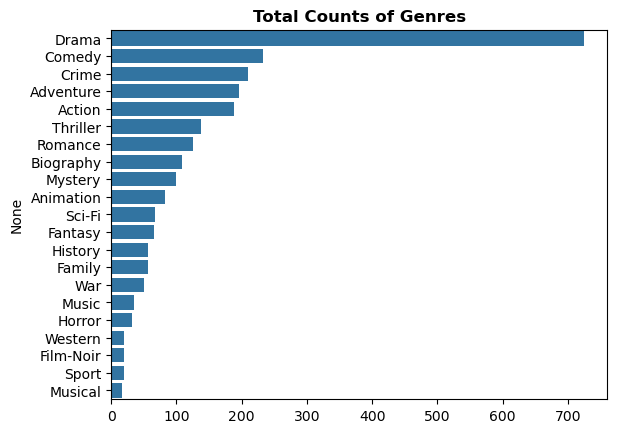

In [10]:
#Total counts of genre
Genre = df['Genre'].str.get_dummies(sep=', ')
sum_of_generes = Genre.sum().sort_values(ascending=False)
sns.barplot(x=sum_of_generes.values, y=sum_of_generes.keys(), )
plt.title('Total Counts of Genres', fontsize=12, weight=600)
plt.show()

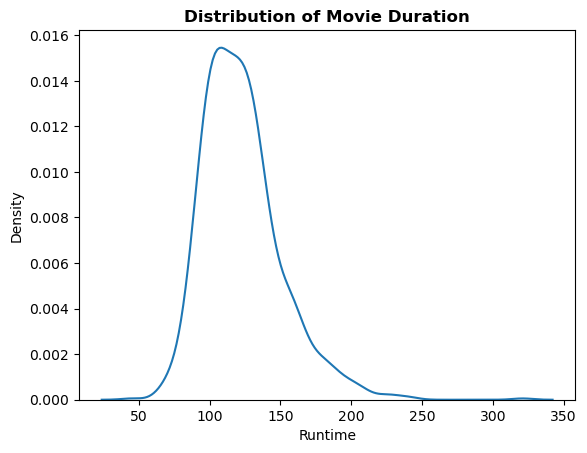

In [11]:
#Distribution of movie duration
sns.kdeplot(x='Runtime',data=df)
plt.title('Distribution of Movie Duration', fontsize=12, weight=600)
plt.show()

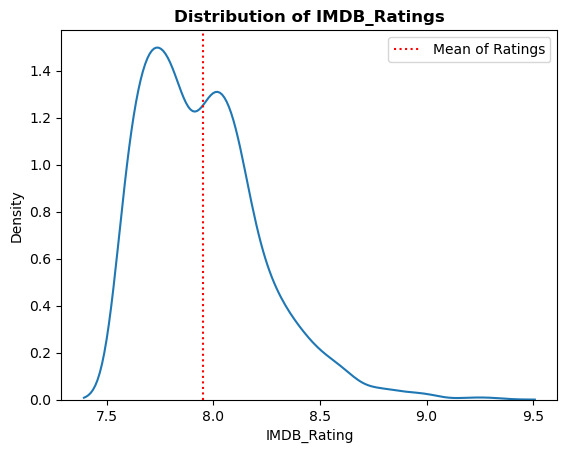

In [12]:
#Distributions of IMDB_Ratings
sns.kdeplot(x='IMDB_Rating',data=df)
plt.axvline(df['IMDB_Rating'].mean(), linestyle=':', c='r',label='Mean of Ratings')
plt.legend()
plt.title('Distribution of IMDB_Ratings', fontsize=12, weight=600)
plt.show()

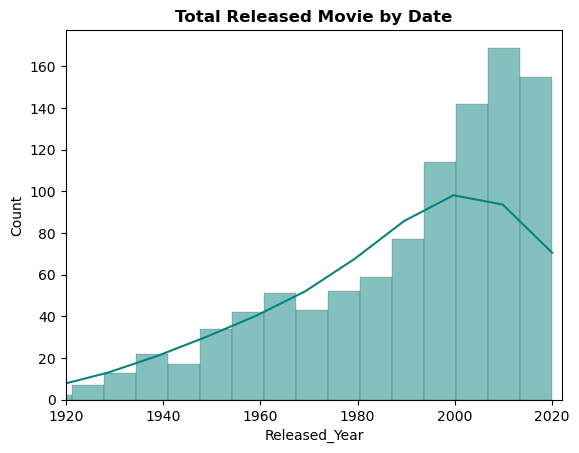

In [13]:
#Total Released_Movies by Date
sns.histplot(data=df, x='Released_Year', kde=True, color='#09837f')
plt.axis(xmin=1920, xmax=2022)
plt.title('Total Released Movie by Date', fontsize=12, weight=600)
plt.show()

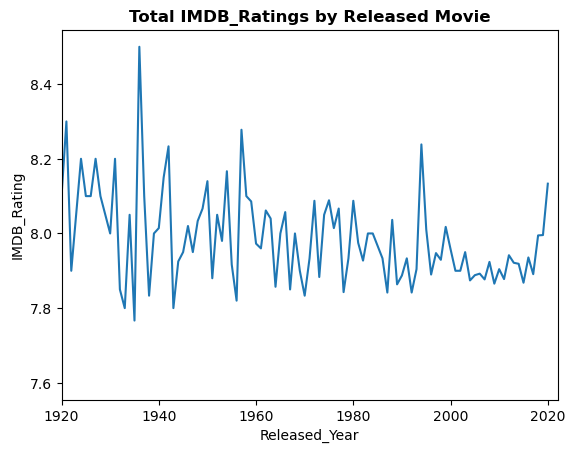

In [14]:
#Total IMDB_Ratings by Released Movies
sns.lineplot(x='Released_Year', y='IMDB_Rating', errorbar=None, data=df)
plt.axis(xmin=1920, xmax=2022)
plt.title('Total IMDB_Ratings by Released Movie', fontsize=12, weight=600)
plt.show()

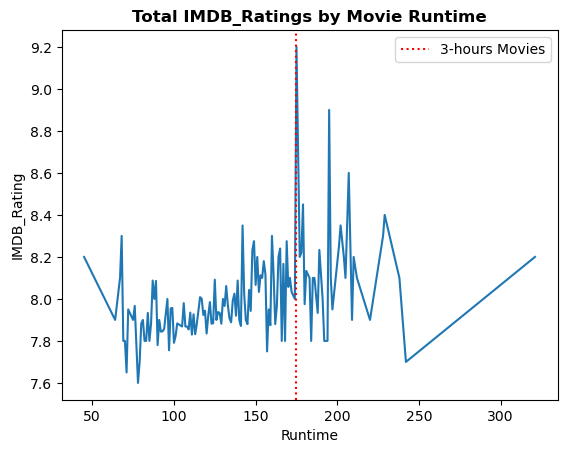

In [15]:
#Total IMDB_Ratings by Movie Runtime
sns.lineplot(x='Runtime', y='IMDB_Rating', errorbar=None, data=df)
plt.axvline(175, linestyle=':', c='r',label='3-hours Movies') # 3-hours
plt.legend()
plt.title('Total IMDB_Ratings by Movie Runtime', fontsize=12, weight=600)
plt.show()

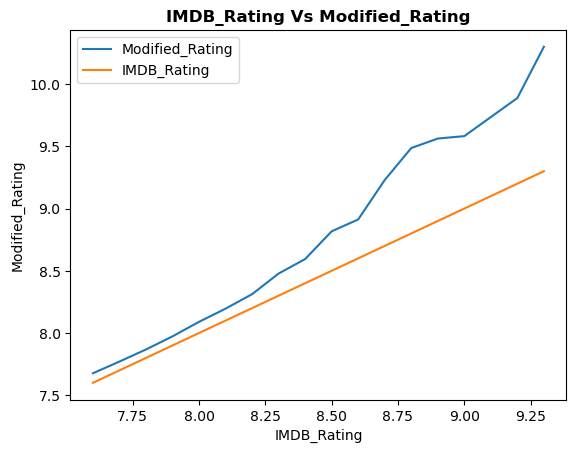

In [16]:
#IMDB_Rating vs Modified_Rating
sns.lineplot(x='IMDB_Rating', y='Modified_Rating', errorbar=None, data=df, label='Modified_Rating')
sns.lineplot(x='IMDB_Rating', y='IMDB_Rating', errorbar=None, data=df, label='IMDB_Rating')
plt.title('IMDB_Rating Vs Modified_Rating', fontsize=12, weight=600)
plt.legend()
plt.show()

In [17]:
# Recommendation System
content = (df['Series_Title'].str.cat(df[['Overview', "Stars", "Director", "Genre"]], sep=" ")).to_list()
recom_df = pd.DataFrame(content, columns=["Content"], index = df.Series_Title)
print('#'*29)
print('Example for conent of Movies: ')
print('#'*29, '\n')
print(recom_df["Content"][1])

#############################
Example for conent of Movies: 
############################# 

The Godfather An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son. Marlon Brando, Al Pacino, James Caan, Diane Keaton Francis Ford Coppola Crime, Drama


C:\Users\Neha\AppData\Local\Temp\ipykernel_11936\2136560747.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(recom_df["Content"][1])


In [18]:
recom_df.head()

,Content
Series_Title,
The Shawshank Redemption,The Shawshank Redemption Two imprisoned men bo...
The Godfather,The Godfather An organized crime dynasty's agi...
The Dark Knight,The Dark Knight When the menace known as the J...
The Godfather: Part II,The Godfather: Part II The early life and care...
12 Angry Men,12 Angry Men A jury holdout attempts to preven...


In [19]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(recom_df['Content'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(1000, 10231)

In [20]:
# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cos_df = pd.DataFrame(cosine_sim, columns=df.Series_Title)
cos_df['Series_Title'] = df.Series_Title
cos_df = cos_df[['Series_Title'] + cos_df.columns[:-1].to_list()]
cos_df.head()

Series_Title,Series_Title,The Shawshank Redemption,The Godfather,The Dark Knight,The Godfather: Part II,12 Angry Men,The Lord of the Rings: The Return of the King,Pulp Fiction,Schindler's List,Inception,...,Giù la testa,Kelly's Heroes,The Jungle Book,Blowup,A Hard Day's Night,Breakfast at Tiffany's,Giant,From Here to Eternity,Lifeboat,The 39 Steps
0,The Shawshank Redemption,1.000000,0.001984,0.001683,0.001836,0.023860,0.021895,0.073767,0.001632,0.000000,...,0.001881,0.0,0.000000,0.002054,0.000000,0.001940,0.002102,0.001801,0.022209,0.000000
1,The Godfather,0.001984,1.000000,0.015041,0.327234,0.017135,0.001886,0.017218,0.001749,0.000000,...,0.017105,0.0,0.000000,0.002202,0.000000,0.002079,0.019114,0.001930,0.001835,0.012796
2,The Dark Knight,0.001683,0.015041,1.000000,0.026807,0.008137,0.008025,0.008176,0.001483,0.054006,...,0.001710,0.0,0.000000,0.001867,0.000000,0.001763,0.001911,0.001637,0.001556,0.005426
3,The Godfather: Part II,0.001836,0.327234,0.026807,1.000000,0.015859,0.001745,0.015935,0.020152,0.000000,...,0.013100,0.0,0.009482,0.002038,0.009726,0.040865,0.026771,0.001786,0.021140,0.035639
4,12 Angry Men,0.023860,0.017135,0.008137,0.015859,1.000000,0.022676,0.021256,0.001690,0.000000,...,0.001948,0.0,0.000000,0.014863,0.010094,0.002009,0.002177,0.001865,0.012386,0.006181


In [21]:
#Construct a reverse map of indices and movie titles
idxs = pd.Series(df.index, index=df.Series_Title)

# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title):
    # Get the index of the movie that matches the title
    idx = idxs[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df.iloc[movie_indices]

In [22]:
get_recommendations("Toy Story")

,Series_Title,Released_Year,Genre,Runtime,Overview,Stars,Director,IMDB_Rating,Modified_Rating,Meta_score,Gross
101,Toy Story,1995,"Animation, Adventure, Comedy",81,A cowboy doll is profoundly threatened and jea...,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney",John Lasseter,8.3,8.672016,95.0,191796233.0
516,Toy Story 2,1999,"Animation, Adventure, Comedy",92,"When Woody is stolen by a toy collector, Buzz ...","Ash Brannon, Lee Unkrich, Tom Hanks, Tim Allen",John Lasseter,7.9,8.116747,88.0,245852179.0
596,Toy Story 4,2019,"Animation, Adventure, Comedy",100,"When a new toy called ""Forky"" joins Woody and ...","Tom Hanks, Tim Allen, Annie Potts, Tony Hale",Josh Cooley,7.8,7.876828,84.0,434038008.0
151,Toy Story 3,2010,"Animation, Adventure, Comedy",103,The toys are mistakenly delivered to a day-car...,"Tom Hanks, Tim Allen, Joan Cusack, Ned Beatty",Lee Unkrich,8.2,8.515762,92.0,415004880.0
991,Kelly's Heroes,1970,"Adventure, Comedy, War",144,A group of U.S. soldiers sneaks across enemy l...,"Clint Eastwood, Telly Savalas, Don Rickles, Ca...",Brian G. Hutton,7.6,7.608736,50.0,1378435.0
699,Midnight Cowboy,1969,Drama,113,A naive hustler travels from Texas to New York...,"Dustin Hoffman, Jon Voight, Sylvia Miles, John...",John Schlesinger,7.8,7.832802,79.0,44785053.0
642,The Count of Monte Cristo,2002,"Action, Adventure, Drama",131,"A young man, falsely imprisoned by his jealous...","Jim Caviezel, Guy Pearce, Christopher Adamson,...",Kevin Reynolds,7.8,7.844837,61.0,54234062.0
837,Zelig,1983,Comedy,79,"""Documentary"" about a man who can look and act...","Woody Allen, Mia Farrow, Patrick Horgan, John ...",Woody Allen,7.7,7.706382,NaN,11798616.0
668,La double vie de Véronique,1991,"Drama, Fantasy, Music",98,Two parallel stories about two identical women...,"Irène Jacob, Wladyslaw Kowalski, Halina Grygla...",Krzysztof Kieslowski,7.8,7.807458,86.0,1999955.0
680,Down by Law,1986,"Comedy, Crime, Drama",107,"Two men are framed and sent to jail, where the...","Tom Waits, John Lurie, Roberto Benigni, Nicole...",Jim Jarmusch,7.8,7.809813,75.0,1436000.0


In [23]:
movie = 'Inception' # 'Write Your Favourate Movie here '
get_recommendations(movie)

,Series_Title,Released_Year,Genre,Runtime,Overview,Stars,Director,IMDB_Rating,Modified_Rating,Meta_score,Gross
8,Inception,2010,"Action, Adventure, Sci-Fi",148,A thief who steals corporate secrets through t...,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",Christopher Nolan,8.8,9.680904,74.0,292576195.0
155,Batman Begins,2005,"Action, Adventure",140,"After training with his mentor, Batman begins ...","Christian Bale, Michael Caine, Ken Watanabe, L...",Christopher Nolan,8.2,8.753581,70.0,206852432.0
754,(500) Days of Summer,2009,"Comedy, Drama, Romance",95,An offbeat romantic comedy about a woman who d...,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...",Marc Webb,7.7,7.892903,76.0,32391374.0
21,Interstellar,2014,"Adventure, Drama, Sci-Fi",169,A team of explorers travel through a wormhole ...,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",Christopher Nolan,8.6,9.241613,74.0,188020017.0
934,Mysterious Skin,2004,Drama,105,A teenage hustler and a young man obsessed wit...,"Brady Corbet, Joseph Gordon-Levitt, Elisabeth ...",Gregg Araki,7.6,7.617623,73.0,697181.0
412,Kagemusha,1980,"Drama, History, War",180,A petty thief with an utter resemblance to a s...,"Tatsuya Nakadai, Tsutomu Yamazaki, Ken'ichi Ha...",Akira Kurosawa,8.0,8.003066,84.0,NaN
907,50/50,2011,"Comedy, Drama, Romance",100,"Inspired by a true story, a comedy centered on...","Joseph Gordon-Levitt, Seth Rogen, Anna Kendric...",Jonathan Levine,7.6,7.725252,72.0,35014192.0
36,The Prestige,2006,"Drama, Mystery, Sci-Fi",130,"After a tragic accident, two stage magicians e...","Christian Bale, Hugh Jackman, Scarlett Johanss...",Christopher Nolan,8.5,9.002657,66.0,53089891.0
784,The Last Samurai,2003,"Action, Drama",154,An American military advisor embraces the Samu...,"Tom Cruise, Ken Watanabe, Billy Connolly, Will...",Edward Zwick,7.7,7.861759,55.0,111110575.0
243,Catch Me If You Can,2002,"Biography, Crime, Drama",141,"Barely 21 yet, Frank is a skilled forger who h...","Leonardo DiCaprio, Tom Hanks, Christopher Walk...",Steven Spielberg,8.1,8.448469,75.0,164615351.0


In [ ]:
!streamlit run main.py

In [35]:
!python -m unittest test_app.py

Recommendations: ['Dev.D' 'Mystic River' 'Lucky Number Slevin' 'Unforgiven'
 'Koe no katachi']


..
----------------------------------------------------------------------
Ran 2 tests in 0.019s

OK


In [36]:
!pip install pytest

Defaulting to user installation because normal site-packages is not writeable


In [39]:
!pytest test_app.py --html=report.html

============================= test session starts =============================
platform win32 -- Python 3.12.4, pytest-7.4.4, pluggy-1.0.0
rootdir: C:\Users\Neha\myproject
plugins: html-4.1.1, metadata-3.1.1, anyio-4.2.0
collected 2 items

test_app.py ..                                                           [100%]

----- Generated html report: file:///C:/Users/Neha/myproject/report.html ------
============================== 2 passed in 4.50s ==============================


In [38]:
!pip install pytest-html

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import os
os.startfile('report.html')

In [9]:
!npm install -g firebase-tools

'npm' is not recognized as an internal or external command,
operable program or batch file.
